# Import Libraries and Load Dataset

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
price = pd.read_csv('https://raw.githubusercontent.com/pararawendy/dibimbing-materials/main/boston.csv')

In [ ]:
price.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Good

# Split Data : Train - Validation - Test

In [ ]:
from sklearn.model_selection import train_test_split

feature = price.drop(columns='medv')
target = price[['medv']]

feature_price_pretrain, feature_price_test, target_price_pretrain, target_price_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_price_train, feature_price_validation, target_price_train, target_price_validation = train_test_split(feature_price_pretrain, target_price_pretrain, test_size=0.20, random_state=42)

# Multicollinearity Study

In [ ]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_price_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.750939
2,zn,2.473421
3,indus,3.741988
4,chas,1.110042
5,nox,4.585650
6,rm,1.972174
7,age,3.127443
8,dis,4.390458
9,rad,7.182410
10,tax,8.268145


Observation:
* VIF Score for `nox`, `dis`, `rad`, `tax` are above 4.
* Let's check multicollinearity on heatmap correlation.

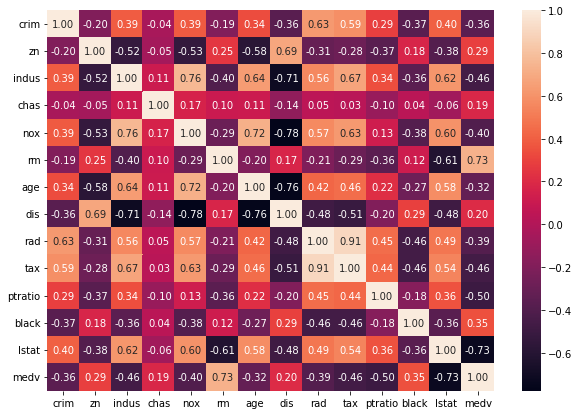

In [ ]:
# heatmap correlation
price_train = pd.concat([feature_price_train, target_price_train], axis=1)
corr = price_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Observation:
* `tax` and `rad` is highly correlated each other (correlation = 0.91).
* `tax` is more correlated with target variable than `rad`. So we decide to drop `rad` column.

## Drop Multicollinear Features

In [ ]:
feature_price_train = feature_price_train.drop(columns=['rad'])
feature_price_validation = feature_price_validation.drop(columns=['rad'])
feature_price_test = feature_price_test.drop(columns=['rad'])

# Recheck VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_price_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,crim,1.615076
2,zn,2.415036
3,indus,3.500250
4,chas,1.097962
5,nox,4.552308
6,rm,1.923266
7,age,3.119817
8,dis,4.390362
9,tax,3.191363
10,ptratio,1.804558


VIF score for `nox` and `dis` are slightly above 4. It's still acceptable. No need to drop.

# Linear Regression

## Model Training

In [ ]:
from sklearn.linear_model import LinearRegression

# define the model
linear_reg = LinearRegression()

# train the model
X_price_train = feature_price_train.to_numpy()
y_price_train = target_price_train.to_numpy()

linear_reg.fit(X_price_train, y_price_train)

LinearRegression()

In [ ]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_price_train
model = linear_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_[0]] + list(model.coef_[0])
})

coef_df

,feature,coefficient
0,intercept,22.828774
1,crim,-0.076956
2,zn,0.025653
3,indus,-0.005538
4,chas,3.299622
5,nox,-17.872107
6,rm,5.168419
7,age,-0.004688
8,dis,-1.509215
9,tax,0.000791


Sample coeff interpretation:

An increase of 1 point in rm (Number rooms average), while the other
features are kept fixed, is associated with an
increase of 5.168 point in medv.

## Model Diagnostic

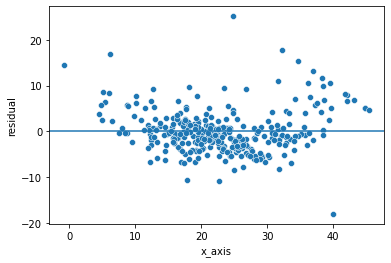

In [ ]:
# calculate residuals
y_predict_train = linear_reg.predict(X_price_train)
residual = y_price_train - y_predict_train

#preprocess shape
y_predict_train = np.array([value for nested_array in y_predict_train for value in nested_array])
residual = np.array([value for nested_array in residual for value in nested_array])

# prepare dataframe
# >1 predictor --> predicted value VS residual
df_resid = pd.DataFrame({
    'x_axis': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="x_axis", y="residual")
plt.axhline(0)
plt.show()

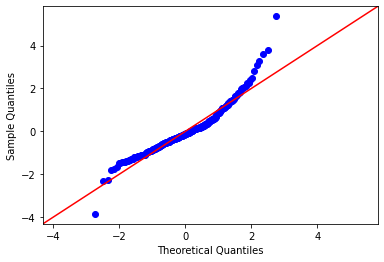

In [ ]:
# QQplot
from sklearn.preprocessing import StandardScaler

std_resid = StandardScaler().fit_transform(residual.reshape(-1,1))
std_resid = np.array([value for nested_array in std_resid for value in nested_array])

import statsmodels.api as sm
sm.qqplot(std_resid, line='45')
plt.show()

Assumption:
1. Linear relationships OK. The horizontal line y=0 is sufficient to represent the entire residual point.
2. Variance stable: NO. The variation is from small (on the left) to wide (on the right).
3. Independent residuals: OK. There is no conspicuous pattern in the adjacent residuals.
4. Residuals distribution: OK. Mostly residuals are normally distributed.

## Model Evaluation

### Training Error

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_price_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_price_train))))

R-squared for training data is 0.6824059419421845
RMSE for training data is 4.679035139957256


### Testing Error

In [ ]:
# prepare prediction result on test data
X_price_test = feature_price_test.to_numpy()
y_predict_test = linear_reg.predict(X_price_test)

# ground truth target
y_price_test = target_price_test.to_numpy()

In [ ]:
from sklearn.metrics import mean_squared_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_price_test))))

RMSE for testing data is 5.193927767323389


Interpretation:

68.24% of variability of medv is successfully explained
using all the features in the model.

The standard deviation of prediction errors is 5.193. i.e. from the regression line, the residuals mostly deviate between +- 5.193.

# Ridge Regression

## Train Multiple Models
with different alpha (lambda)

In [ ]:
from sklearn.linear_model import Ridge

# train the model
X_price_train = feature_price_train.to_numpy()
y_price_train = target_price_train.to_numpy()
y_price_train = y_price_train.reshape(len(y_price_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_price_train, y_price_train)
ridge_reg_pointone.fit(X_price_train, y_price_train)
ridge_reg_one.fit(X_price_train, y_price_train)
ridge_reg_ten.fit(X_price_train, y_price_train)

Ridge(alpha=10, random_state=42)

## Find Best Model (alpha)
Based on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

X_price_validation = feature_price_validation.to_numpy()
y_price_validation = target_price_validation.to_numpy()
y_price_validation = y_price_validation.reshape(len(y_price_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_price_validation)
    rmse = np.sqrt(mean_squared_error(y_price_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 4.960676932957843
RMSE of Ridge regression model with alpha = 0.1 is 4.949412535122791
RMSE of Ridge regression model with alpha = 1.0 is 4.912351371579991
RMSE of Ridge regression model with alpha = 10 is 4.871717983886228


The smallest RMSE is alpha = 10

## Model Evaluation

In [ ]:
ridge_best = ridge_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_price_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,15.064666
1,crim,-0.071408
2,zn,0.033030
3,indus,-0.067858
4,chas,1.955801
5,nox,-1.568248
6,rm,4.783168
7,age,-0.011523
8,dis,-1.260056
9,tax,-0.001976


Sample coeff interpretation:

An increase of 1 point in rm (Number rooms average), while the other
features are kept fixed, is associated with an
increase of 4.783 point in medv.

## Diagnostics Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_price_train)

print('R-squared for training data is {}'.format(r2_score(y_price_train, y_predict_train)))

R-squared for training data is 0.748587526366982


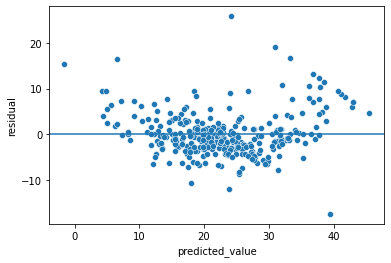

In [ ]:
# calculate residuals
residual = y_price_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption:
1. Linear relationships OK. The horizontal line y=0 is sufficient to represent the entire residual point.
2. Variance stable: NO. The variation is from small (on the left) to wide (on the right).
3. Independent residuals: OK. There is no conspicuous pattern in the adjacent residuals.

## Training Error

In [ ]:
# prepare prediction result on train data
X_price_train = feature_price_train.to_numpy()
y_predict_train = ridge_best.predict(X_price_train)

# ground truth target
y_price_train = target_price_train.to_numpy()
y_price_train = y_price_train.reshape(len(y_price_train),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_price_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_price_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_price_train, y_predict_train)))

RMSE for training data is 4.778640361040111
MAE for training data is 3.3776762058865626
MAPE for training data is 0.16868073663359498


## Testing Error

In [ ]:
# prepare prediction result on test data
X_price_test = feature_price_test.to_numpy()
y_predict_test = ridge_best.predict(X_price_test)

# ground truth target
y_price_test = target_price_test.to_numpy()
y_price_test = y_price_test.reshape(len(y_price_test),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_price_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_price_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_price_test, y_predict_test)))

RMSE for testing data is 5.158908333657057
MAE for testing data is 3.2444816457044965
MAPE for testing data is 0.17618402626767926


## Interpretation

Summary:
Just Right

MAPE on training data is about 16.86% and 17.61% for testing data.

MAPE on training data indicates that it is not underfit.
MAPE on test data indicates that it is also not overfit.

From test data, the standard deviation of prediction errors is 5.158. i.e. from the regression line, the residuals mostly deviate between +- 5.158.

On average, our prediction deviates the true medv by 3.244. Moreover, this 3.244 is equivalent to 17.61% deviation relative to the medv.

# Lasso Regression

## Train Multiple Models

In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_price_train = feature_price_train.to_numpy()
y_price_train = target_price_train.to_numpy()
y_price_train = y_price_train.reshape(len(y_price_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_price_train, y_price_train)
lasso_reg_pointone.fit(X_price_train, y_price_train)
lasso_reg_one.fit(X_price_train, y_price_train)
lasso_reg_ten.fit(X_price_train, y_price_train)

Lasso(alpha=10, random_state=42)

## Find Best Model (alpha)
Based on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

X_price_validation = feature_price_validation.to_numpy()
y_price_validation = target_price_validation.to_numpy()
y_price_validation = y_price_validation.reshape(len(y_price_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_price_validation)
    rmse = np.sqrt(mean_squared_error(y_price_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 4.934105658639752
RMSE of Lasso regression model with alpha = 0.1 is 4.907145314259478
RMSE of Lasso regression model with alpha = 1.0 is 4.845855910636398
RMSE of Lasso regression model with alpha = 10 is 5.426622694252769


The smallest RMSE is alpha = 1

## Model Evaluation

In [ ]:
lasso_best = lasso_reg_one

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_price_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,25.823435
1,crim,-0.041076
2,zn,0.025273
3,indus,-0.000000
4,chas,0.000000
5,nox,-0.000000
6,rm,2.504122
7,age,0.022055
8,dis,-0.599362
9,tax,-0.002994


Sample coeff interpretation:

An increase of 1 point in rm (Number rooms average), while the other
features are kept fixed, is associated with an
increase of 2.504 point in medv.

## Diagnostics Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_price_train)

print('R-squared for training data is {}'.format(r2_score(y_price_train, y_predict_train)))

R-squared for training data is 0.7056815963218595


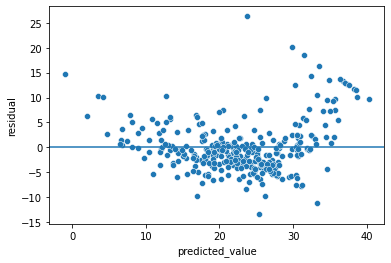

In [ ]:
# calculate residuals
residual = y_price_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Assumption:
1. Linear relationships OK. The horizontal line y=0 is sufficient to represent the entire residual point.
2. Variance stable: NO. The variation is from small (on the left) to wide (on the right).
3. Independent residuals: OK. There is no conspicuous pattern in the adjacent residuals.

## Training Error

In [ ]:
# prepare prediction result on train data
X_price_train = feature_price_train.to_numpy()
y_predict_train = lasso_best.predict(X_price_train)

# ground truth target
y_price_train = target_price_train.to_numpy()
y_price_train = y_price_train.reshape(len(y_price_train),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_price_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_price_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_price_train, y_predict_train)))

RMSE for training data is 5.170346463296143
MAE for training data is 3.6858416211465084
MAPE for training data is 0.1749128202363825


## Testing Error

In [ ]:
# prepare prediction result on test data
X_price_test = feature_price_test.to_numpy()
y_predict_test = lasso_best.predict(X_price_test)

# ground truth target
y_price_test = target_price_test.to_numpy()
y_price_test = y_price_test.reshape(len(y_price_test),)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_price_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_price_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_price_test, y_predict_test)))

RMSE for testing data is 5.125494212319777
MAE for testing data is 3.3980507105960682
MAPE for testing data is 0.17856606338732206


## Interpretation

Summary:
Just Right

MAPE on training data is about 17.49% and 17.85% for testing data.

MAPE on training data indicates that it is not underfit.
MAPE on test data indicates that it is also not overfit.

From test data, the standard deviation of prediction errors is 5.125. i.e. from the regression line, the residuals mostly deviate between +- 5.125.

On average, our prediction deviates the true medv by 3.398. Moreover, this 3.398 is equivalent to 17.85% deviation relative to the medv.

# Summary

R-squared for ridge model on training data is 74.85%

R-squared for lasso model on training data is 70.56%

Both of ridge and lasso model are just right. Not underfit or overfit.

Best model is ridge model due to 74.85% of variability of medv is successfully explained using all the features in the model.